# Topic 1: Introduction to Bayesian Inference

## Learning Objectives
- Understand the philosophical foundations of Bayesian vs Frequentist approaches
- Master Bayes' theorem and its components
- Apply Bayesian reasoning to practical problems
- Interpret probability as degree of belief

In [1]:
!pip install pymc arviz

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pymc as pm
import arviz as az
from scipy.optimize import minimize_scalar

plt.style.use('seaborn-v0_8')
np.random.seed(42)

/home/obote/anaconda3/envs/ml_env/lib/python3.10/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


## 1. Bayesian vs Frequentist Philosophy

### Frequentist Approach
- **Probability**: Long-run frequency of events
- **Parameters**: Fixed but unknown constants
- **Inference**: Based on sampling distributions
- **Confidence Intervals**: "If we repeat this procedure many times, 95% of intervals will contain the true parameter"

### Bayesian Approach
- **Probability**: Degree of belief or uncertainty
- **Parameters**: Random variables with distributions
- **Inference**: Update beliefs with data
- **Credible Intervals**: "There's a 95% probability the parameter lies in this interval"

## 2. Bayes' Theorem - The Foundation

### Mathematical Formulation

$$P(\theta|D) = \frac{P(D|\theta) \cdot P(\theta)}{P(D)}$$

### Components:

1. **Posterior** $P(\theta|D)$: Updated belief about $\theta$ after observing data $D$
2. **Likelihood** $P(D|\theta)$: Probability of observing data $D$ given parameter $\theta$
3. **Prior** $P(\theta)$: Initial belief about $\theta$ before observing data
4. **Evidence** $P(D) = \int P(D|\theta)P(\theta)d\theta$: Normalizing constant

### Proportional Form (often used):
$$P(\theta|D) \propto P(D|\theta) \cdot P(\theta)$$

**Posterior ∝ Likelihood × Prior**

## 3. Example 1: Medical Diagnosis

A medical test for a rare disease:
- Disease prevalence: 1 in 1000 people (0.1%)
- Test sensitivity: 99% (correctly identifies disease)
- Test specificity: 95% (correctly identifies no disease)

**Question**: If someone tests positive, what's the probability they have the disease?

Prior probability of disease: 0.1%
Probability of positive test: 5.1%
Posterior probability of disease given positive test: 1.9%


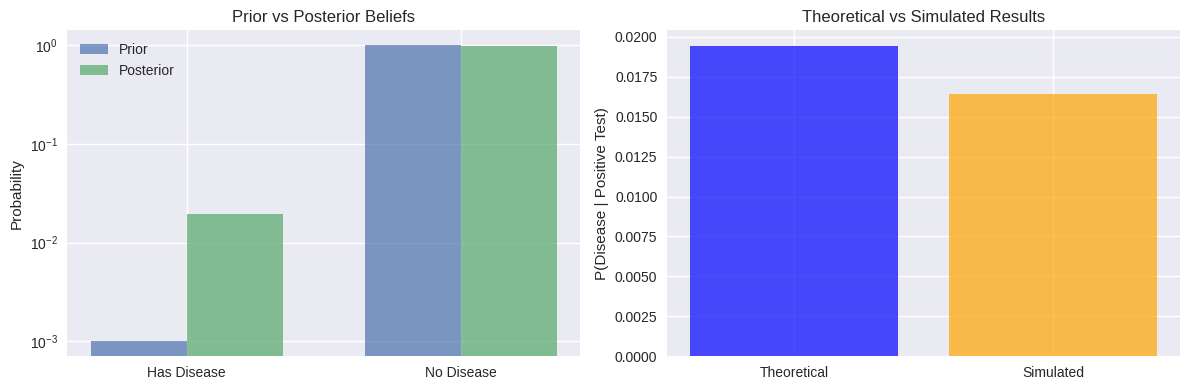


Simulation with 100,000 people:
Simulated probability: 1.6%


In [3]:
# Define probabilities
P_disease = 0.001  # Prior: disease prevalence
P_no_disease = 1 - P_disease

P_pos_given_disease = 0.99  # Sensitivity
P_pos_given_no_disease = 0.05  # 1 - Specificity

# Calculate evidence P(positive test)
P_positive = (P_pos_given_disease * P_disease + 
              P_pos_given_no_disease * P_no_disease)

# Apply Bayes' theorem
P_disease_given_pos = (P_pos_given_disease * P_disease) / P_positive

print(f"Prior probability of disease: {P_disease:.1%}")
print(f"Probability of positive test: {P_positive:.1%}")
print(f"Posterior probability of disease given positive test: {P_disease_given_pos:.1%}")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Prior vs Posterior
categories = ['Has Disease', 'No Disease']
prior = [P_disease, P_no_disease]
posterior = [P_disease_given_pos, 1 - P_disease_given_pos]

x = np.arange(len(categories))
width = 0.35

ax1.bar(x - width/2, prior, width, label='Prior', alpha=0.7)
ax1.bar(x + width/2, posterior, width, label='Posterior', alpha=0.7)
ax1.set_ylabel('Probability')
ax1.set_title('Prior vs Posterior Beliefs')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.legend()
ax1.set_yscale('log')

# Tree diagram simulation
n_people = 100000
has_disease = np.random.binomial(1, P_disease, n_people)
test_results = np.where(has_disease, 
                       np.random.binomial(1, P_pos_given_disease, n_people),
                       np.random.binomial(1, P_pos_given_no_disease, n_people))

# Among positive tests, how many actually have disease?
positive_tests = test_results == 1
true_positives = np.sum(has_disease[positive_tests])
total_positives = np.sum(positive_tests)

simulated_prob = true_positives / total_positives

ax2.bar(['Theoretical', 'Simulated'], 
        [P_disease_given_pos, simulated_prob], 
        color=['blue', 'orange'], alpha=0.7)
ax2.set_ylabel('P(Disease | Positive Test)')
ax2.set_title('Theoretical vs Simulated Results')

plt.tight_layout()
plt.show()

print(f"\nSimulation with {n_people:,} people:")
print(f"Simulated probability: {simulated_prob:.1%}")

## 4. Example 2: Parameter Estimation with Continuous Priors

Estimating the success rate of a new treatment.

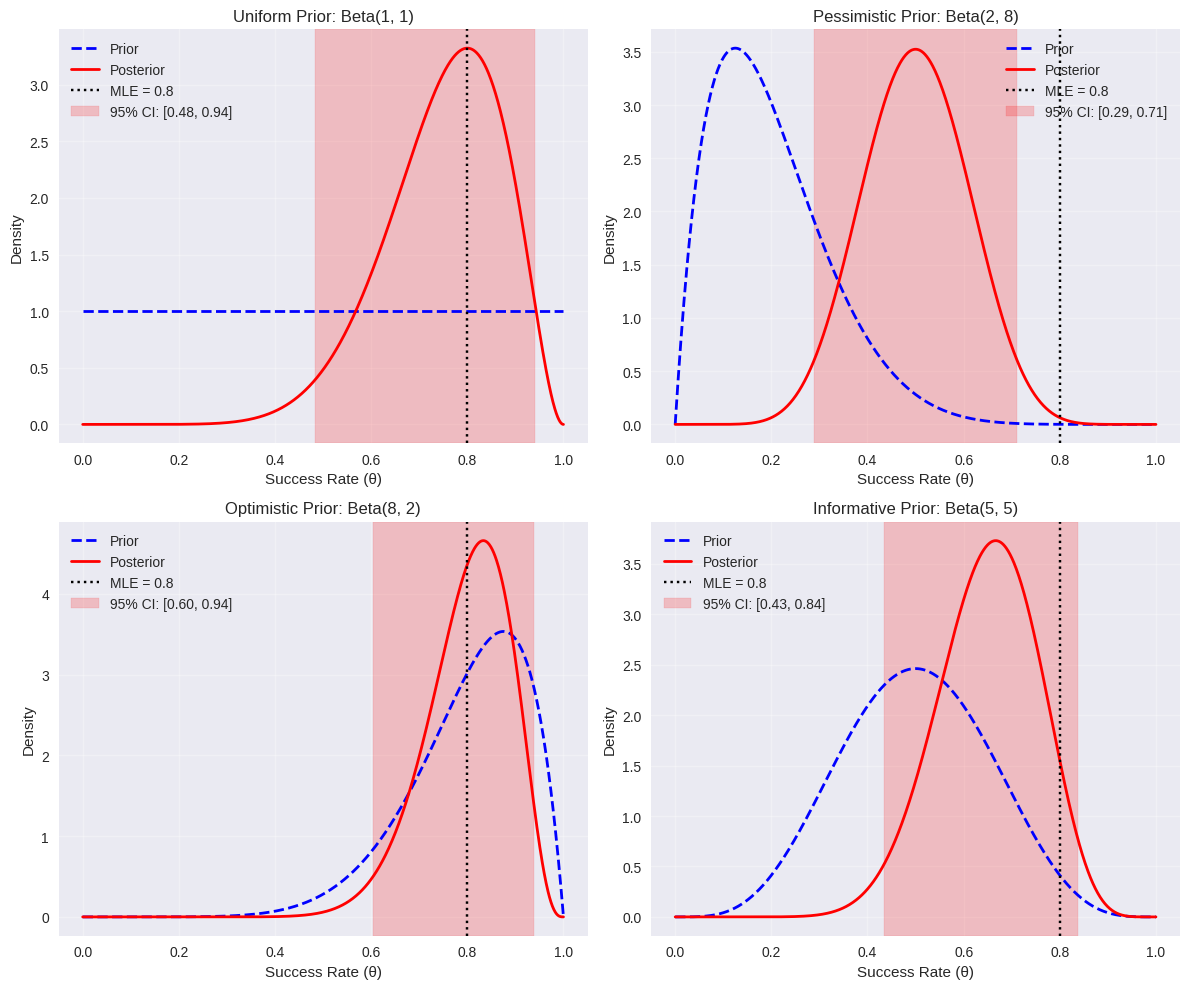


Posterior Summary Statistics:
Prior		Mean	95% Credible Interval
---------------------------------------------
Uniform     	0.750	[0.482, 0.940]
Pessimistic 	0.500	[0.289, 0.711]
Optimistic  	0.800	[0.604, 0.939]
Informative 	0.650	[0.434, 0.837]


In [4]:
# Data: 8 successes out of 10 trials
successes = 8
trials = 10

# Different priors to show their impact
priors = {
    'Uniform': (1, 1),      # Beta(1,1) = Uniform(0,1)
    'Pessimistic': (2, 8),  # Beta(2,8) - expect low success rate
    'Optimistic': (8, 2),   # Beta(8,2) - expect high success rate
    'Informative': (5, 5)   # Beta(5,5) - centered at 0.5
}

x = np.linspace(0, 1, 1000)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, (name, (alpha_prior, beta_prior)) in enumerate(priors.items()):
    # Prior
    prior_dist = stats.beta(alpha_prior, beta_prior)
    
    # Posterior (Beta is conjugate to Binomial)
    alpha_post = alpha_prior + successes
    beta_post = beta_prior + trials - successes
    posterior_dist = stats.beta(alpha_post, beta_post)
    
    # Plot
    axes[i].plot(x, prior_dist.pdf(x), 'b--', label='Prior', linewidth=2)
    axes[i].plot(x, posterior_dist.pdf(x), 'r-', label='Posterior', linewidth=2)
    axes[i].axvline(successes/trials, color='black', linestyle=':', 
                   label=f'MLE = {successes/trials:.1f}')
    
    # Credible interval
    ci_lower, ci_upper = posterior_dist.ppf([0.025, 0.975])
    axes[i].axvspan(ci_lower, ci_upper, alpha=0.2, color='red', 
                   label=f'95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]')
    
    axes[i].set_title(f'{name} Prior: Beta({alpha_prior}, {beta_prior})')
    axes[i].set_xlabel('Success Rate (θ)')
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nPosterior Summary Statistics:")
print("Prior\t\tMean\t95% Credible Interval")
print("-" * 45)
for name, (alpha_prior, beta_prior) in priors.items():
    alpha_post = alpha_prior + successes
    beta_post = beta_prior + trials - successes
    posterior_dist = stats.beta(alpha_post, beta_post)
    
    mean = posterior_dist.mean()
    ci_lower, ci_upper = posterior_dist.ppf([0.025, 0.975])
    
    print(f"{name:<12}\t{mean:.3f}\t[{ci_lower:.3f}, {ci_upper:.3f}]")

## 5. Sequential Learning - Updating Beliefs

One of the key advantages of Bayesian inference is the ability to update beliefs as new data arrives.

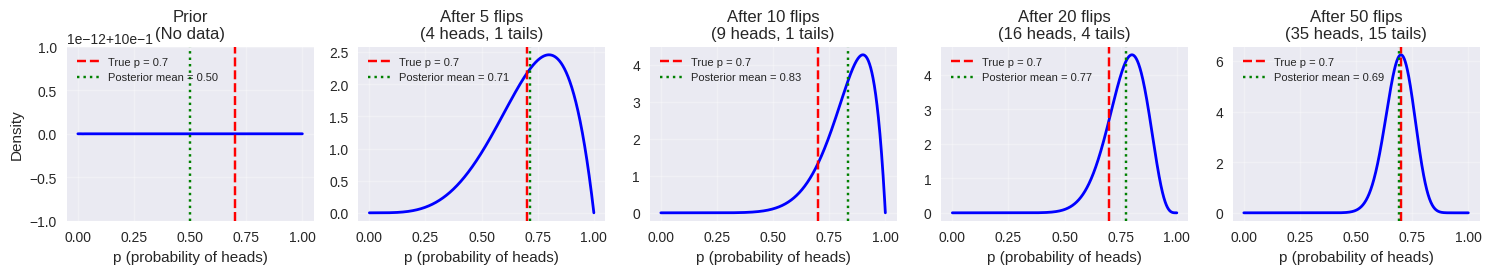

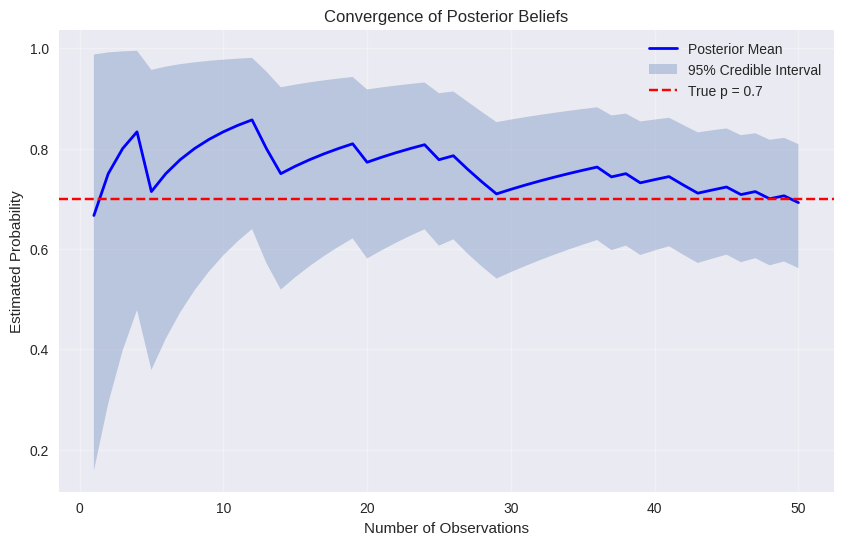

In [5]:
# Simulate sequential coin flips
true_p = 0.7
n_flips = 50
flips = np.random.binomial(1, true_p, n_flips)

# Start with uniform prior
alpha, beta = 1, 1
x = np.linspace(0, 1, 1000)

# Track evolution of beliefs
update_points = [0, 5, 10, 20, 50]
fig, axes = plt.subplots(1, len(update_points), figsize=(15, 3))

for i, n in enumerate(update_points):
    if n > 0:
        heads = np.sum(flips[:n])
        alpha_n = alpha + heads
        beta_n = beta + n - heads
    else:
        alpha_n, beta_n = alpha, beta
        heads = 0
    
    posterior = stats.beta(alpha_n, beta_n)
    
    axes[i].plot(x, posterior.pdf(x), 'b-', linewidth=2)
    axes[i].axvline(true_p, color='red', linestyle='--', label=f'True p = {true_p}')
    axes[i].axvline(posterior.mean(), color='green', linestyle=':', 
                   label=f'Posterior mean = {posterior.mean():.2f}')
    
    if n > 0:
        axes[i].set_title(f'After {n} flips\n({heads} heads, {n-heads} tails)')
    else:
        axes[i].set_title('Prior\n(No data)')
    
    axes[i].set_xlabel('p (probability of heads)')
    if i == 0:
        axes[i].set_ylabel('Density')
    axes[i].legend(fontsize=8)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show convergence of posterior mean
means = []
cis_lower = []
cis_upper = []

for n in range(1, n_flips + 1):
    heads = np.sum(flips[:n])
    alpha_n = alpha + heads
    beta_n = beta + n - heads
    posterior = stats.beta(alpha_n, beta_n)
    
    means.append(posterior.mean())
    ci_lower, ci_upper = posterior.ppf([0.025, 0.975])
    cis_lower.append(ci_lower)
    cis_upper.append(ci_upper)

plt.figure(figsize=(10, 6))
n_range = range(1, n_flips + 1)
plt.plot(n_range, means, 'b-', label='Posterior Mean', linewidth=2)
plt.fill_between(n_range, cis_lower, cis_upper, alpha=0.3, label='95% Credible Interval')
plt.axhline(true_p, color='red', linestyle='--', label=f'True p = {true_p}')
plt.xlabel('Number of Observations')
plt.ylabel('Estimated Probability')
plt.title('Convergence of Posterior Beliefs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 6. Practical Application: A/B Testing

Compare two website designs using Bayesian methods.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_A, p_B]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


A/B Test Results:
Design A: 120/1000 = 12.0% conversion rate
Design B: 140/1000 = 14.0% conversion rate
Observed difference: 2.0%

Bayesian Analysis:
Probability B is better than A: 91.1%
Probability B is >1% better than A: 75.2%


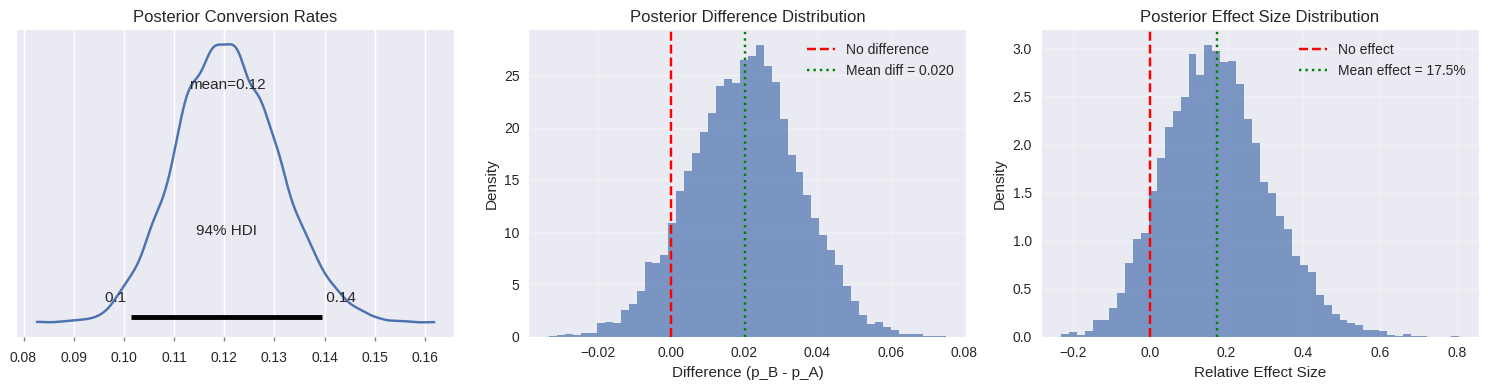

In [6]:
# A/B test data
# Design A: 120 conversions out of 1000 visitors
# Design B: 140 conversions out of 1000 visitors

conversions_A, visitors_A = 120, 1000
conversions_B, visitors_B = 140, 1000

# Use PyMC for Bayesian A/B test
with pm.Model() as ab_test_model:
    # Priors for conversion rates
    p_A = pm.Beta('p_A', alpha=1, beta=1)
    p_B = pm.Beta('p_B', alpha=1, beta=1)
    
    # Likelihoods
    obs_A = pm.Binomial('obs_A', n=visitors_A, p=p_A, observed=conversions_A)
    obs_B = pm.Binomial('obs_B', n=visitors_B, p=p_B, observed=conversions_B)
    
    # Derived quantities
    diff = pm.Deterministic('difference', p_B - p_A)
    effect_size = pm.Deterministic('effect_size', (p_B - p_A) / p_A)
    
    # Sample
    trace = pm.sample(2000, return_inferencedata=True, random_seed=42)

# Analysis
print("A/B Test Results:")
print(f"Design A: {conversions_A}/{visitors_A} = {conversions_A/visitors_A:.1%} conversion rate")
print(f"Design B: {conversions_B}/{visitors_B} = {conversions_B/visitors_B:.1%} conversion rate")
print(f"Observed difference: {(conversions_B/visitors_B - conversions_A/visitors_A):.1%}")

# Posterior analysis
diff_samples = trace.posterior['difference'].values.flatten()
prob_B_better = np.mean(diff_samples > 0)
prob_significant = np.mean(diff_samples > 0.01)  # >1% improvement

print(f"\nBayesian Analysis:")
print(f"Probability B is better than A: {prob_B_better:.1%}")
print(f"Probability B is >1% better than A: {prob_significant:.1%}")

# Visualizations
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Posterior distributions
az.plot_posterior(trace, var_names=['p_A', 'p_B'], ax=axes[0])
axes[0].set_title('Posterior Conversion Rates')

# Difference distribution
axes[1].hist(diff_samples, bins=50, alpha=0.7, density=True)
axes[1].axvline(0, color='red', linestyle='--', label='No difference')
axes[1].axvline(np.mean(diff_samples), color='green', linestyle=':', 
               label=f'Mean diff = {np.mean(diff_samples):.3f}')
axes[1].set_xlabel('Difference (p_B - p_A)')
axes[1].set_ylabel('Density')
axes[1].set_title('Posterior Difference Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Effect size
effect_samples = trace.posterior['effect_size'].values.flatten()
axes[2].hist(effect_samples, bins=50, alpha=0.7, density=True)
axes[2].axvline(0, color='red', linestyle='--', label='No effect')
axes[2].axvline(np.mean(effect_samples), color='green', linestyle=':', 
               label=f'Mean effect = {np.mean(effect_samples):.1%}')
axes[2].set_xlabel('Relative Effect Size')
axes[2].set_ylabel('Density')
axes[2].set_title('Posterior Effect Size Distribution')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Key Takeaways

### Advantages of Bayesian Approach:
1. **Intuitive interpretation**: Probability as degree of belief
2. **Incorporates prior knowledge**: Can use expert knowledge or previous studies
3. **Sequential learning**: Easy to update beliefs with new data
4. **Uncertainty quantification**: Full posterior distribution, not just point estimates
5. **Decision-theoretic framework**: Natural for decision making under uncertainty

### Challenges:
1. **Prior specification**: Choosing appropriate priors can be subjective
2. **Computational complexity**: Often requires sophisticated sampling methods
3. **Communication**: May be harder to explain to non-statisticians

### When to Use Bayesian Methods:
- When you have prior information to incorporate
- When you need to quantify uncertainty
- For sequential decision making
- When sample sizes are small
- For complex hierarchical models

## Exercises

1. **Medical Test**: A new COVID test has 95% sensitivity and 98% specificity. If the prevalence is 2%, what's the probability someone who tests positive actually has COVID?

2. **Quality Control**: A factory produces items with a defect rate θ. You observe 3 defects in 100 items. Using a Beta(2,20) prior, find the posterior distribution and 90% credible interval.

3. **Sequential Learning**: Start with a uniform prior for a coin's bias. After observing the sequence HTHTHT, what's your posterior belief? How does it change if you observe 10 more heads?

4. **A/B Testing**: Design A has 50/500 conversions, Design B has 60/500. Using uniform priors, what's the probability that B is better than A?

## Next: Topic 2 - Prior Distributions

In the next notebook, we'll dive deeper into:
- Types of prior distributions
- Conjugate priors and their benefits
- Non-informative and improper priors
- Prior elicitation techniques